# DCGAN Enhancement Experiments
## Architecture Modifications & Hyperparameter Tuning

### Component 1: Layer Modifications (10 marks)
- Deeper networks (more layers)
- Wider networks (more feature maps)
- Residual connections
- Self-attention mechanism
- Different activation functions

### Component 2: Hyperparameter Tuning (10 marks)
- Learning rates: [0.0001, 0.0002, 0.0005, 0.001]
- Batch sizes: [32, 64, 128]
- Latent dimensions: [32, 64, 100, 128]
- Beta parameters optimization
- Optimizer comparison

### Metrics:
- Generator & Discriminator Losses
- Training Time
- Image Quality Visual Assessment

In [57]:
# Import Libraries
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import kagglehub
import time
import json
from collections import defaultdict

# Set random seed
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [58]:
from PIL import Image, ImageEnhance
import io

# Load the dataset from parquet
splits = {'train': 'data/train-00000-of-00001-fa0b6bb53e3b3d16.parquet', 
          'validation': 'data/validation-00000-of-00001-49f45a5ed0b4ad18.parquet', 
          'test': 'data/test-00000-of-00001-48d445de0e368b7c.parquet'}

df = pd.read_parquet("hf://datasets/James-A/Minecraft-16x-Dataset/" + splits["train"])

print("DataFrame shape (before filtering):", df.shape)
print("DataFrame columns:", df.columns.tolist())

DataFrame shape (before filtering): (1366, 19)
DataFrame columns: ['image', 'texture_name', 'texture_size', 'type', 'primary_colors', 'secondary_colors', 'pattern_description', 'texture_style', 'lighting_reflection', 'symmetry', 'tileable_direction', 'visual_complexity', 'illumination_effects', 'usage_context', 'functionality', 'related_items_blocks', 'mimicry_biome_association', 'special_effects_in_game_functionality', 'overall_texture_description']


In [59]:
def extract_types_from_row(type_str):
    """Extract individual types from a row's type column"""
    if pd.isna(type_str):
        return []
    
    parts = type_str.split(' - ')
    if len(parts) > 1:
        types_part = parts[1]
        individual_types = [t.strip() for t in types_part.split(',')]
        return individual_types
    return []

def get_primary_label(type_str, priority_types):
    """
    Get the primary label based on priority types.
    Returns the first matching type from priority_types, or None if no match.
    """
    types = extract_types_from_row(type_str)
    
    # Check each priority type in order
    for priority_type in priority_types:
        if priority_type in types:
            return priority_type
    
    return None

filter_types = [
    'Utility',
    'Decorative',
    'Wood',
    'Plant',
    'Stone',
    'Potion',
    'Food',
    'Tool',
    'Spawn Egg',
    'Light Source'
]

In [60]:
# Apply labeling
df['label'] = df['type'].apply(lambda x: get_primary_label(x, filter_types))

# Check results before filtering
print("Label distribution before filtering:")
print(df['label'].value_counts(dropna=False))
print(f"\nRows with no matching label (will be dropped): {df['label'].isna().sum()}")

# Drop rows that don't have any of the top 10 types
df_filtered = df[df['label'].notna()].copy()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"Rows dropped: {len(df) - len(df_filtered)}")

Label distribution before filtering:
label
Utility       378
None          329
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Rows with no matching label (will be dropped): 329

Original dataset size: 1366
Filtered dataset size: 1037
Rows dropped: 329


In [61]:
print("\nFinal label distribution:")
print(df_filtered['label'].value_counts())

# Create numeric labels for training (0-9)
label_to_idx = {label: idx for idx, label in enumerate(filter_types)}
df_filtered['label_idx'] = df_filtered['label'].map(label_to_idx)

print("\nLabel to index mapping:")
for label, idx in label_to_idx.items():
    count = (df_filtered['label'] == label).sum()
    print(f"{idx}: {label} ({count} samples)")

images = df_filtered['image'].tolist()
labels = df_filtered['label_idx'].values

print(f"\nFinal number of images: {len(images)}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")


Final label distribution:
label
Utility       378
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Label to index mapping:
0: Utility (378 samples)
1: Decorative (211 samples)
2: Wood (49 samples)
3: Plant (110 samples)
4: Stone (86 samples)
5: Potion (62 samples)
6: Food (50 samples)
7: Tool (45 samples)
8: Spawn Egg (46 samples)
9: Light Source (0 samples)

Final number of images: 1037
Labels shape: (1037,)
Unique labels: [0 1 2 3 4 5 6 7 8]


In [62]:
import torchvision.transforms as transforms

def augment_image(img, apply_augmentation_prob=0.6):
    """
    Apply random augmentations to increase dataset variety
    apply_augmentation_prob: probability of applying ANY augmentation (default 0.9 = 90% chance)
    """
    # Skip augmentation entirely with some probability
    if np.random.rand() > apply_augmentation_prob:
        return img  # Return original image
    
    '''# Random horizontal flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Random vertical flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Random 90-degree rotations (75% chance)
    if np.random.rand() > 0.25:
        rotation = np.random.choice([0, 90, 180, 270])
        if rotation > 0:
            img = img.rotate(rotation)'''
    
    # Random brightness adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(np.random.uniform(0.8, 1.2))
    
    # Random contrast adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(np.random.uniform(0.85, 1.15))
    
    return img

# Usage in your loop:
num_augmentations = 3

In [63]:
# Define target size
target_size = (16, 16)

# Process images: resize, convert to RGB
data_list = []
labels_list = []

augment = True

for img_data in images:
    # If image is stored as bytes, convert to PIL Image
    if isinstance(img_data, dict) and 'bytes' in img_data:
        img = Image.open(io.BytesIO(img_data['bytes']))
    elif isinstance(img_data, bytes):
        img = Image.open(io.BytesIO(img_data))
    else:
        img = img_data  # Already a PIL Image
    
    # Resize if needed
    if img.size != target_size:
        img = img.resize(target_size, Image.NEAREST)
    
    # Convert RGBA to RGB (handle transparency)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        img = img.convert('RGB')

    data_list.append(np.array(img))
    labels_list.append(labels[idx])

    if augment:
        for _ in range(num_augmentations - 1):
            aug_img = augment_image(img.copy())
            data_list.append(np.array(aug_img))
            labels_list.append(labels[idx])

# Convert to numpy array
data = np.array(data_list)
labels = np.array(labels_list) 
print("Shape: ", data.shape)

Shape:  (3111, 16, 16, 3)


c:\Users\ASUS\torch-gpu\.venv\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [64]:
# Prepare tensors
images_tensor = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Normalize to [-1, 1]
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0
images_tensor = images_tensor * 2.0 - 1.0

print(f"Data shape: {images_tensor.shape}")
print(f"Range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

Data shape: torch.Size([3111, 3, 16, 16])
Range: [-1.00, 1.00]


In [65]:
# Helper Functions
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def create_loader(images, labels, batch_size, workers=2):
    dataset = TensorDataset(images, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                     num_workers=workers, drop_last=True)

def plot_comparison(results_dict, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for name, res in results_dict.items():
        plt.plot(res['G_losses'], label=name, alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Generator Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for name, res in results_dict.items():
        plt.plot(res['D_losses'], label=name, alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Discriminator Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("✓ Helper functions loaded")

✓ Helper functions loaded


## COMPONENT 1: Architecture Modifications

In [66]:
# Baseline Architecture
class BaselineGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=z_dim, 
                out_channels=ngf*8, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=ngf*8, 
                out_channels=ngf*4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=ngf*4,
                out_channels=nc,
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class BaselineDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Baseline architecture")

✓ Baseline architecture


In [67]:
# Architecture 1: Deeper Network
class DeeperGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*16, 2, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class DeeperDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*4, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Deeper architecture")

✓ Deeper architecture


In [68]:
# Architecture 2: Wider Network
class WiderGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=64, nc=3):  # ngf doubled
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class WiderDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):  # ndf doubled
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Wider architecture")

✓ Wider architecture


In [69]:
# Architecture 3: Residual Connections
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class ResidualGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )
        self.res_blocks = nn.Sequential(ResBlock(ngf*8), ResBlock(ngf*8))
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        return self.upsample(x)

print("✓ Residual architecture")

✓ Residual architecture


In [70]:
# Training Function with Image Display
def train_gan(netG, netD, loader, config, num_epochs, name="Experiment"):
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, config['z_dim'], 1, 1, device=device)
    
    optimizerD = optim.Adam(netD.parameters(), lr=config['lrD'], 
                           betas=(config['beta1'], config['beta2']))
    optimizerG = optim.Adam(netG.parameters(), lr=config['lrG'], 
                           betas=(config['beta1'], config['beta2']))
    
    G_losses, D_losses, img_list = [], [], []
    start_time = time.time()
    
    print(f"\n{'='*60}\nTraining: {name}\n{'='*60}")
    
    for epoch in range(num_epochs):
        for i, data in enumerate(loader):
            # Update Discriminator
            netD.zero_grad()
            real = data[0].to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
            
            output = netD(real).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            
            noise = torch.randn(b_size, config['z_dim'], 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.0)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
            
            # Update Generator
            netG.zero_grad()
            label.fill_(1.0)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}] G: {np.mean(G_losses[-len(loader):]):.4f} D: {np.mean(D_losses[-len(loader):]):.4f}")
    
    # Generate final images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake, padding=2, normalize=True, nrow=8)
    img_list.append(img_grid)
    
    # Display generated image for this experiment
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.title(f"Fake Images - {name}", fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()
    
    return {
        'G_losses': G_losses,
        'D_losses': D_losses,
        'img_list': img_list,
        'time': time.time() - start_time,
        'name': name
    }

print("✓ Training function ready")

✓ Training function ready


Dataset ready: 97 batches

REAL IMAGES FROM DATASET


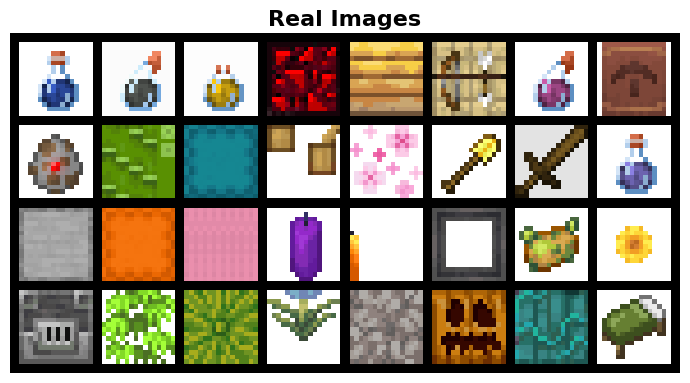

In [ ]:
# Configuration
config = {
    'batch_size': 32,
    'z_dim': 100,
    'lrG': 0.0001,
    'lrD': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'num_epochs': 100
}

arch_results = {}
loader = create_loader(images_tensor, labels_tensor, config['batch_size'])
print(f"Dataset ready: {len(loader)} batches")

# Display Real Images FIRST
print("\n" + "="*70)
print("REAL IMAGES FROM DATASET")
print("="*70)
real_batch = next(iter(loader))
real_images = real_batch[0][:32]  # Take first 32 images

plt.figure(figsize=(7, 7))
plt.axis("off")
plt.title("Real Images", fontsize=16, fontweight='bold')
grid = vutils.make_grid(real_images, nrow=8, padding=2, normalize=True)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()


🔬 EXPERIMENT 1: Baseline

Training: Baseline
Epoch [1/100] G: 1.0597 D: 1.2247
Epoch [2/100] G: 1.1905 D: 1.0495
Epoch [3/100] G: 0.8653 D: 1.2544
Epoch [4/100] G: 0.8468 D: 1.2822
Epoch [5/100] G: 0.9320 D: 1.2033
Epoch [6/100] G: 1.0800 D: 1.0661
Epoch [7/100] G: 1.0177 D: 1.0798
Epoch [8/100] G: 1.0376 D: 1.0330
Epoch [9/100] G: 1.0933 D: 1.0077
Epoch [10/100] G: 1.0983 D: 1.0392
Epoch [11/100] G: 1.0874 D: 1.0928
Epoch [12/100] G: 1.0649 D: 1.0966
Epoch [13/100] G: 1.1642 D: 1.0778
Epoch [14/100] G: 1.1314 D: 1.0685
Epoch [15/100] G: 1.1594 D: 1.0329
Epoch [16/100] G: 1.1144 D: 1.0436
Epoch [17/100] G: 1.1295 D: 1.0374
Epoch [18/100] G: 1.1452 D: 1.0114
Epoch [19/100] G: 1.1888 D: 0.9866
Epoch [20/100] G: 1.2055 D: 0.9785
Epoch [21/100] G: 1.2184 D: 0.9870
Epoch [22/100] G: 1.2572 D: 0.9380
Epoch [23/100] G: 1.2557 D: 0.9532
Epoch [24/100] G: 1.2754 D: 0.9418
Epoch [25/100] G: 1.2972 D: 0.9090
Epoch [26/100] G: 1.3163 D: 0.9221
Epoch [27/100] G: 1.3465 D: 0.8984
Epoch [28/100] G: 

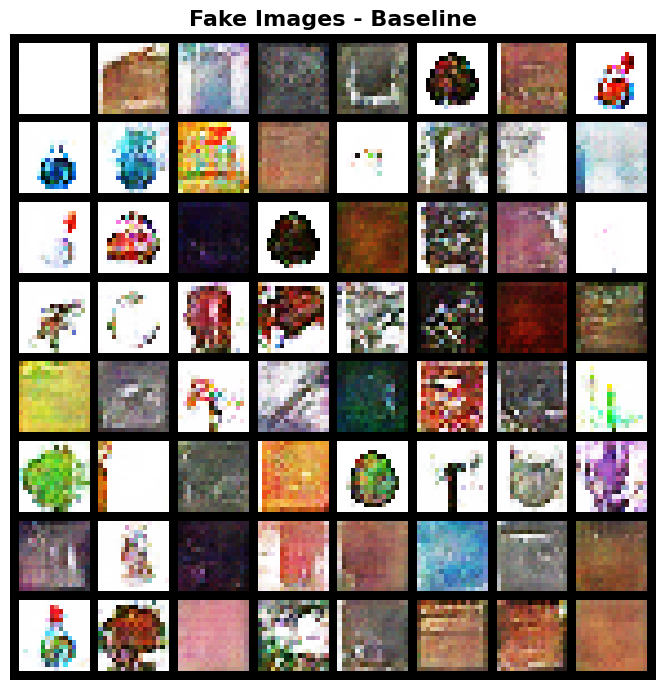

In [72]:
# Experiment 1: Baseline
print("\n🔬 EXPERIMENT 1: Baseline")
netG = BaselineGenerator(config['z_dim'], 32, 3).to(device)
netD = BaselineDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Baseline'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Baseline")


🔬 EXPERIMENT 2: Deeper Network

Training: Deeper
Epoch [1/100] G: 1.7575 D: 0.8758
Epoch [2/100] G: 1.2069 D: 1.2255
Epoch [3/100] G: 1.1305 D: 1.1960
Epoch [4/100] G: 0.9969 D: 1.2486
Epoch [5/100] G: 1.1632 D: 1.1350
Epoch [6/100] G: 1.1242 D: 1.1912
Epoch [7/100] G: 1.2659 D: 1.0849
Epoch [8/100] G: 1.3948 D: 1.0232
Epoch [9/100] G: 1.4577 D: 0.9777
Epoch [10/100] G: 1.4795 D: 0.9730
Epoch [11/100] G: 1.4570 D: 0.9806
Epoch [12/100] G: 1.4804 D: 0.9930
Epoch [13/100] G: 1.5423 D: 0.9566
Epoch [14/100] G: 1.6241 D: 0.8827
Epoch [15/100] G: 1.7762 D: 0.8162
Epoch [16/100] G: 1.8865 D: 0.7965
Epoch [17/100] G: 1.8764 D: 0.7491
Epoch [18/100] G: 1.8990 D: 0.7181
Epoch [19/100] G: 2.0641 D: 0.6944
Epoch [20/100] G: 2.0547 D: 0.6346
Epoch [21/100] G: 2.0478 D: 0.6663
Epoch [22/100] G: 2.1374 D: 0.6085
Epoch [23/100] G: 2.1778 D: 0.5737
Epoch [24/100] G: 2.2371 D: 0.5633
Epoch [25/100] G: 2.2766 D: 0.5398
Epoch [26/100] G: 2.3299 D: 0.5138
Epoch [27/100] G: 2.3319 D: 0.4797
Epoch [28/100]

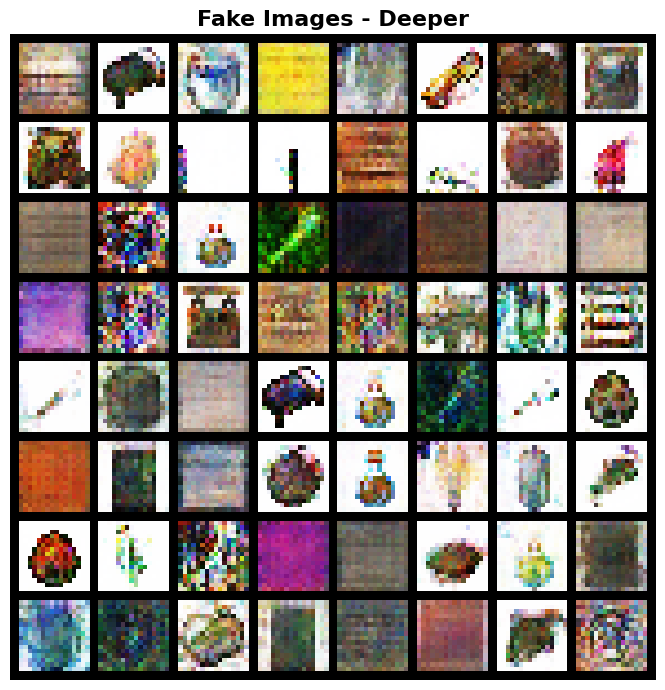

In [73]:
# Experiment 2: Deeper
print("\n🔬 EXPERIMENT 2: Deeper Network")
netG = DeeperGenerator(config['z_dim'], 32, 3).to(device)
netD = DeeperDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Deeper'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Deeper")


🔬 EXPERIMENT 3: Wider Network

Training: Wider
Epoch [1/100] G: 2.3856 D: 0.7421
Epoch [2/100] G: 3.2864 D: 0.2952
Epoch [3/100] G: 1.7144 D: 0.8882
Epoch [4/100] G: 1.7676 D: 0.8804
Epoch [5/100] G: 1.8378 D: 0.7803
Epoch [6/100] G: 1.5622 D: 0.7641
Epoch [7/100] G: 1.6491 D: 0.7668
Epoch [8/100] G: 1.6758 D: 0.8029
Epoch [9/100] G: 1.5969 D: 0.8586
Epoch [10/100] G: 1.7011 D: 0.8625
Epoch [11/100] G: 1.5307 D: 0.8533
Epoch [12/100] G: 1.5170 D: 0.9223
Epoch [13/100] G: 1.5058 D: 0.8660
Epoch [14/100] G: 1.5436 D: 0.8281
Epoch [15/100] G: 1.5978 D: 0.8035
Epoch [16/100] G: 1.6050 D: 0.7860
Epoch [17/100] G: 1.6172 D: 0.7597
Epoch [18/100] G: 1.6766 D: 0.7363
Epoch [19/100] G: 1.7213 D: 0.7133
Epoch [20/100] G: 1.7966 D: 0.6815
Epoch [21/100] G: 1.8668 D: 0.6280
Epoch [22/100] G: 1.8958 D: 0.6275
Epoch [23/100] G: 2.0230 D: 0.6085
Epoch [24/100] G: 2.1218 D: 0.6322
Epoch [25/100] G: 2.0811 D: 0.5643
Epoch [26/100] G: 2.0931 D: 0.5835
Epoch [27/100] G: 2.1051 D: 0.5351
Epoch [28/100] G

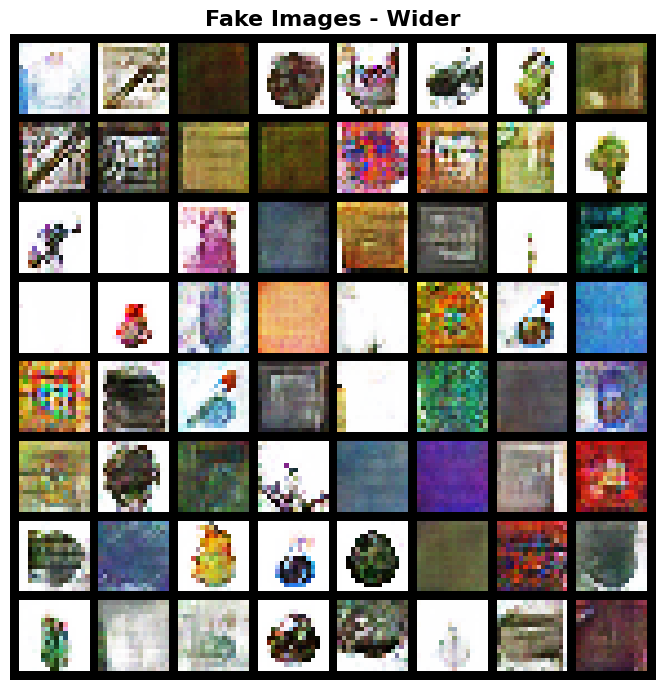

In [74]:
# Experiment 3: Wider
print("\n🔬 EXPERIMENT 3: Wider Network")
netG = WiderGenerator(config['z_dim'], 64, 3).to(device)
netD = WiderDiscriminator(3, 64).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Wider'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Wider")


🔬 EXPERIMENT 4: Residual Connections

Training: Residual
Epoch [1/100] G: 0.3880 D: 2.4867
Epoch [2/100] G: 0.7028 D: 1.8205
Epoch [3/100] G: 0.8270 D: 1.5141
Epoch [4/100] G: 0.9344 D: 1.3174
Epoch [5/100] G: 1.0587 D: 1.1783
Epoch [6/100] G: 1.0965 D: 1.1197
Epoch [7/100] G: 1.1917 D: 1.0537
Epoch [8/100] G: 1.3128 D: 0.9095
Epoch [9/100] G: 1.3407 D: 0.9028
Epoch [10/100] G: 1.4958 D: 0.7778
Epoch [11/100] G: 1.2453 D: 1.0535
Epoch [12/100] G: 0.6468 D: 1.5947
Epoch [13/100] G: 0.6772 D: 1.4452
Epoch [14/100] G: 0.7082 D: 1.4178
Epoch [15/100] G: 0.7121 D: 1.4001
Epoch [16/100] G: 0.7087 D: 1.3972
Epoch [17/100] G: 0.7332 D: 1.3861
Epoch [18/100] G: 0.7369 D: 1.3751
Epoch [19/100] G: 0.7085 D: 1.3862
Epoch [20/100] G: 0.7365 D: 1.3932
Epoch [21/100] G: 0.7246 D: 1.3826
Epoch [22/100] G: 0.7133 D: 1.4063
Epoch [23/100] G: 0.6913 D: 1.4326
Epoch [24/100] G: 0.6985 D: 1.4114
Epoch [25/100] G: 0.6964 D: 1.4043
Epoch [26/100] G: 0.6993 D: 1.4004
Epoch [27/100] G: 0.7153 D: 1.3904
Epoch 

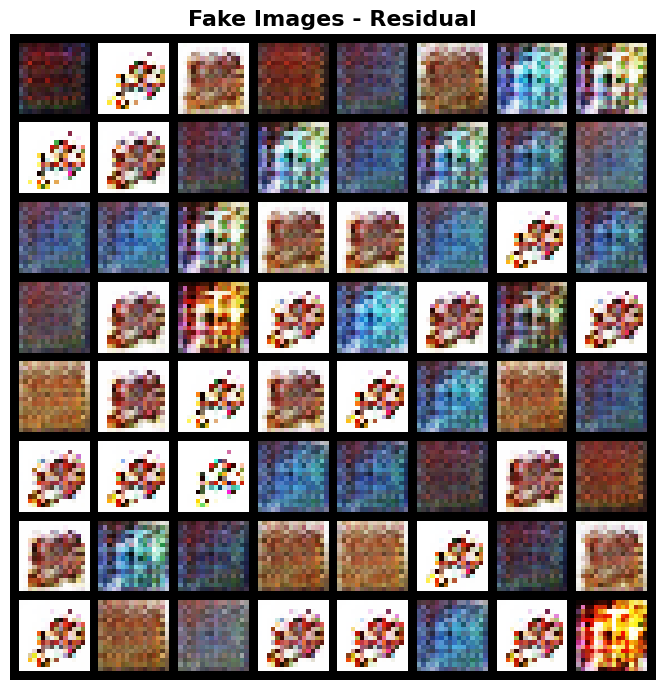

In [75]:
# Experiment 4: Residual
print("\n🔬 EXPERIMENT 4: Residual Connections")
netG = ResidualGenerator(config['z_dim'], 32, 3).to(device)
netD = BaselineDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Residual'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Residual")


COMPONENT 1: ARCHITECTURE RESULTS SUMMARY


,Architecture,Avg G Loss,Avg D Loss,Final G Loss,Time (min)
0,Baseline,1.7475,0.7288,2.5080,5.72
1,Deeper,3.3511,0.3598,4.9759,5.96
2,Wider,2.8422,0.4207,5.1632,5.76
3,Residual,0.8573,1.3279,1.0313,6.95



GENERATED IMAGES COMPARISON


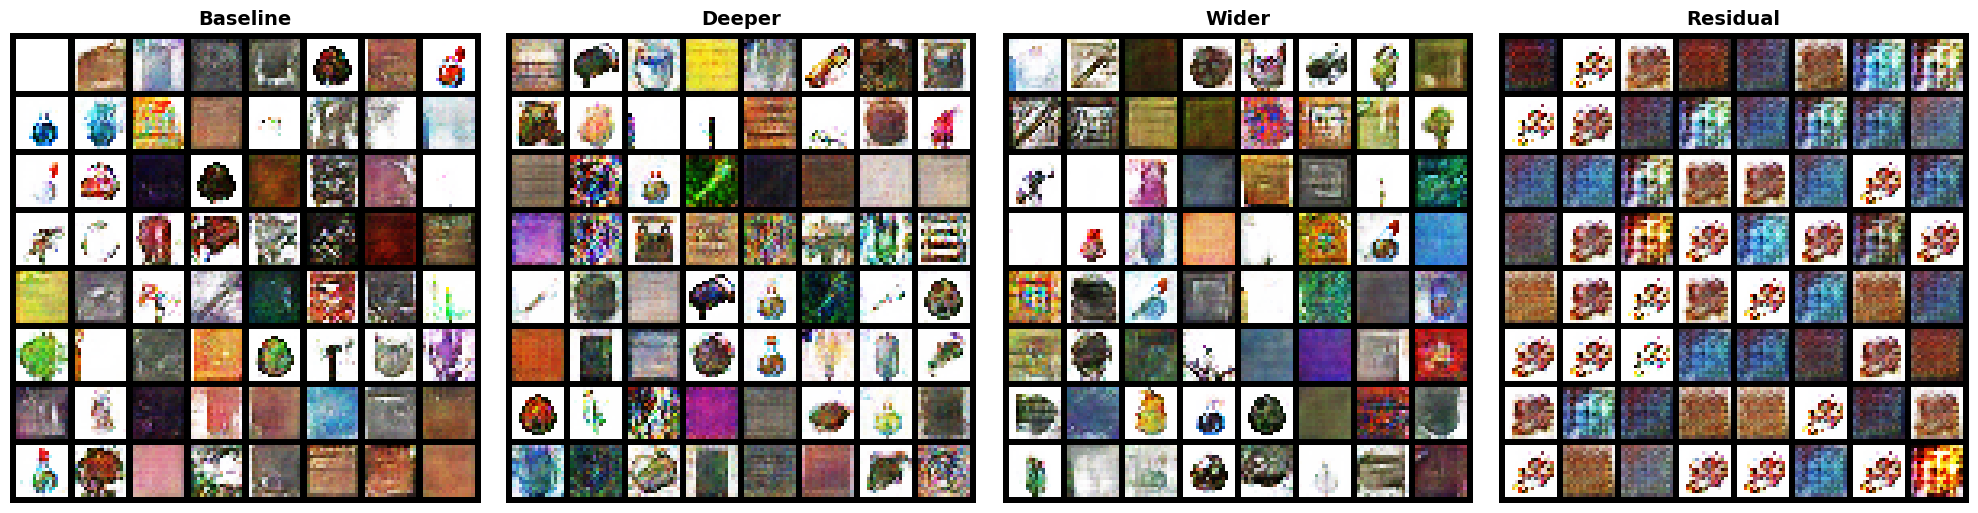

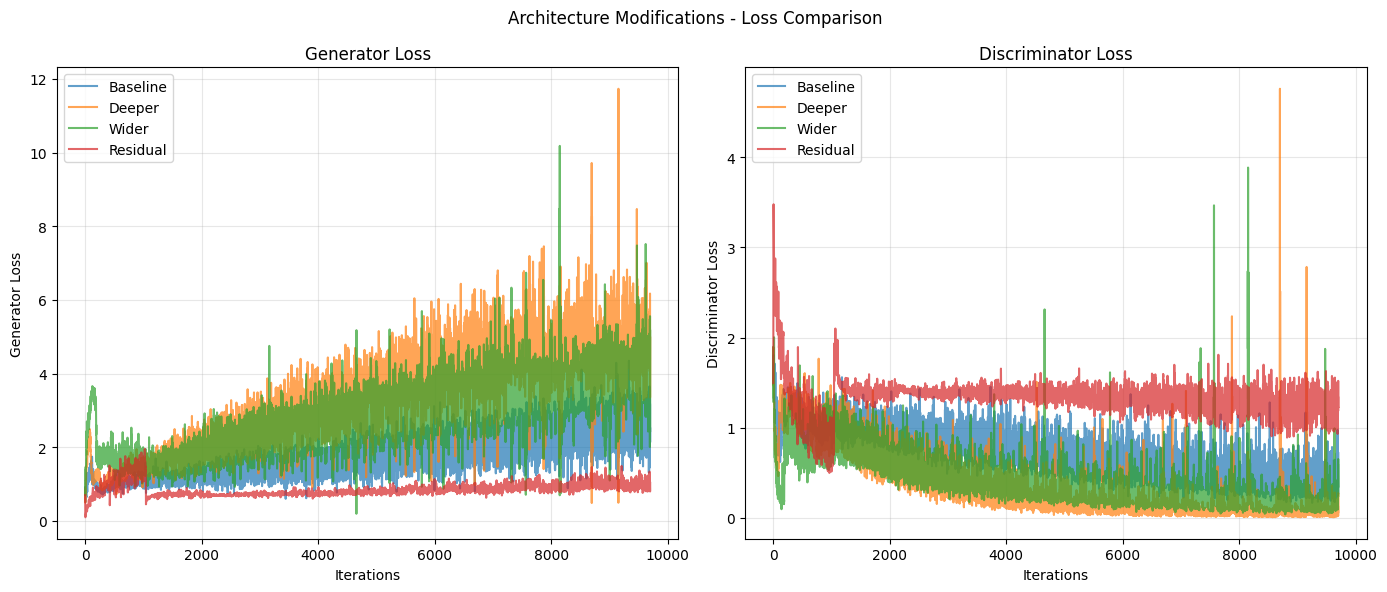

: 

In [ ]:
# Architecture Results
print("\n" + "="*70)
print("COMPONENT 1: ARCHITECTURE RESULTS SUMMARY")
print("="*70)

df_arch = pd.DataFrame([{
    'Architecture': name,
    'Avg G Loss': f"{np.mean(res['G_losses']):.4f}",
    'Avg D Loss': f"{np.mean(res['D_losses']):.4f}",
    'Final G Loss': f"{res['G_losses'][-1]:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in arch_results.items()])

display(df_arch)

# Show all generated images side by side
print("\n" + "="*70)
print("GENERATED IMAGES COMPARISON")
print("="*70)

n_arch = len(arch_results)
fig, axes = plt.subplots(1, n_arch, figsize=(5*n_arch, 5))

if n_arch == 1:
    axes = [axes]

for idx, (name, res) in enumerate(arch_results.items()):
    img = res['img_list'][-1]
    axes[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[idx].set_title(name, fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot losses
plot_comparison(arch_results, "Architecture Modifications - Loss Comparison")